# Introduction

Ensembling is a commonly used technique in Kaggle competitions to combine predictions of multiple models and get stronger predictions that hopefully achieve better score on the leaderboard. The idea is that combining different models with varying strengths and weaknesses can lead to better generalization on unseen data. There are various approaches to ensembling. In this notebook, we will explore a few of these approaches and evaluate their effectiveness in a regression task, and see how they compare to each other. While the focus in this notebook is on regression, with small adjustments, many of the techniques discussed here can be easily adapted for classification problems.

# Imports and configs

In [1]:
!pip install -q hillclimbers

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from hillclimbers import climb_hill, partial
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import shutil
import pickle
import gc
import os

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e9/train.csv'
    test_path = '/kaggle/input/playground-series-s4e9/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e9/sample_submission.csv'

    target = 'price'
    n_folds = 5
    seed = 228

# Data preprocessing

The dataset in this competition contains only two numerical features: `model_year` and `milage`. The rest are categorical and need to be processed accordingly. Additionally, three of the categorical columns—`fuel_type`, `clean_title`, and `accident`—contain missing values and need to be handled for models that can't deal with missing values on their own. 

I will not add any new features even though there are columns such as `engine` that contain a lot of information about the car. This is due to the synthetic nature of the dataset, which contains noise, and engineering new features often just adds to this noise.

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

Here I'm combining every preprocessing step into a function. The function
- Reduces the cardinality of `milage`
- Applies a simple mapping to `clean_title` which contains only two unique values
- One-hot-encodes `accident`
- Imputes missing values
- Encodes `model`, `fuel_type`, and `engine` using `OrdinalEncoder`

The remaining columns, `brand`, `transmission`, `ext_col`, and `int_col` are target encoded. However, to avoid leakage this is done in the `Trainer` class later on.

In [5]:
def get_data():
    train = pd.read_csv(CFG.train_path, index_col='id')
    test = pd.read_csv(CFG.test_path, index_col='id')
    
    train['milage'] = train['milage'] // 100
    test['milage'] = test['milage'] // 100
    
    train['clean_title'] = np.where(train['clean_title'] == 'Yes', 1, 0)
    test['clean_title'] = np.where(test['clean_title'] == 'Yes', 1, 0)
    
    oe_cols = [
        'model', 
        'fuel_type', 
        'engine',
    ]
    
    ohe_cols = [
        'accident'
    ]
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False))
    ])
    
    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, ohe_cols),
            ('ord', ordinal_transformer, oe_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False,
    ).set_output(transform='pandas')
    
    X = train.drop(CFG.target, axis=1)
    y = train[CFG.target]
    X_test = test.copy()
    
    X_preprocessed = preprocessor.fit_transform(X)
    X_test_preprocessed = preprocessor.transform(X_test)
    
    return X_preprocessed, y, X_test_preprocessed

Here, we can see that all features are usefull, thus there is no need to eliminate any of the features.

In [6]:
X_mi, y_mi, _ = get_data()

te_cols = ['brand', 'transmission', 'ext_col', 'int_col']
te = TargetEncoder()
X_mi[te_cols] = te.fit_transform(X_mi[te_cols], y_mi)

mutual_info = mutual_info_regression(X_mi, y_mi, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_mi.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
milage,0.646097
engine,0.606354
model_year,0.541621
transmission,0.443028
model,0.419323
clean_title,0.161421
brand,0.153817
ext_col,0.137217
int_col,0.128250
accident_At least 1 accident or damage reported,0.062837


# Training base models

Here, I have created a class to train and cross-validate the base models. I will use this class to train all five of my base models, as well as some of the ensemble models. The class also contains a function that saves OOF predictions of the base models. Feel free to use these OOF files in your own ensemble.

In [7]:
os.mkdir('oof_preds')
os.mkdir('test_preds')

In [8]:
class Trainer:
    def __init__(self, model, CFG, is_ensemble=False, save_preds=False):
        self.model = model
        self.config = CFG
        self.is_ensemble = is_ensemble
        self.save_preds = save_preds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_preds = np.zeros(len(X), dtype=np.float32)
        test_preds = np.zeros(len(X_test), dtype=np.float32)
        
        skf = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            _X_test = X_test.copy()
            if not self.is_ensemble:
                te_cols = ['brand', 'transmission', 'ext_col', 'int_col']
                te = TargetEncoder()
                X_train[te_cols] = te.fit_transform(X_train[te_cols], y_train)
                X_val[te_cols] = te.transform(X_val[te_cols])
                _X_test[te_cols] = te.transform(_X_test[te_cols])
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble:
                coeffs += model.coef_ / self.config.n_folds
            
            y_preds = model.predict(X_val)
            oof_preds[val_idx] = y_preds
            
            temp_test_preds = model.predict(_X_test)
            test_preds += temp_test_preds / self.config.n_folds
            
            score = mean_squared_error(y_val, y_preds, squared=False)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_preds, temp_test_preds, _X_test
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - RMSE: {round(score)}')
            
        overall_score = mean_squared_error(y, oof_preds, squared=False)
        
        print(f'\nOverall RMSE: {round(overall_score)} ± {round(np.std(scores))}')
        
        if self.save_preds:
            self._save_preds(oof_preds, overall_score, 'oof')
            self._save_preds(test_preds, overall_score, 'test')
        
        if self.is_ensemble:
            return oof_preds, test_preds, scores, coeffs[0]
        else:
            return oof_preds, test_preds, scores
        
    def _save_preds(self, preds, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('regressor', '')
        with open(f'{name}_preds/{model_name}_{name}_preds_{round(cv_score)}.pkl', 'wb') as f:
            pickle.dump(preds, f)

In [9]:
def save_submission(test_preds, name, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_preds
    sub.to_csv(f'sub_{name}_{round(score)}.csv', index=False)
    return sub

In [10]:
lgbm_params = {
    'colsample_bytree': 0.5641846558360547,
    'learning_rate': 0.0076680609857264544,
    'max_depth': 35,
    'min_child_samples': 183,
    'min_child_weight': 0.7202301665597771,
    'n_estimators': 411,
    'n_jobs': -1,
    'num_leaves': 431,
    'random_state': 228,
    'reg_alpha': 4.430227550972671,
    'reg_lambda': 0.8334279654558774,
    'subsample': 0.9642789117921036,
    'verbose': -1
}

xgb_params = {
    'colsample_bylevel': 0.9954139069968206,
    'colsample_bynode': 0.9104404597241588,
    'colsample_bytree': 0.9994200442751848,
    'gamma': 1.3161464200360995,
    'learning_rate': 0.009197285095347237,
    'max_depth': 17,
    'min_child_weight': 411.0439744170577,
    'n_estimators': 847,
    'n_jobs': -1,
    'random_state': 228,
    'reg_alpha': 4.065307128570309,
    'reg_lambda': 8.592219226587531,
    'subsample': 0.5007091349122316,
    'verbosity': 0
}

cb_params = {
    'border_count': 229,
    'colsample_bylevel': 0.15556856044132572,
    'depth': 10,
    'iterations': 1724,
    'l2_leaf_reg': 47.76800893648283,
    'learning_rate': 0.012564822193515566,
    'min_data_in_leaf': 257,
    'random_state': 228,
    'random_strength': 0.6341216161996276,
    'subsample': 0.6051236320741833,
    'verbose': False
}

hgb_params = {
    'l2_regularization': 99.14988687043189,
    'learning_rate': 0.04015679297216836,
    'max_depth': 163,
    'max_iter': 1711,
    'max_leaf_nodes': 32,
    'min_samples_leaf': 482,
    'random_state': 228
}

gb_params = {
    'learning_rate': 0.07849442432087823,
    'max_depth': 35,
    'max_features': 0.9056494041270672,
    'max_leaf_nodes': 461,
    'min_samples_leaf': 0.016405520047344413,
    'min_samples_split': 0.31183798193591405,
    'min_weight_fraction_leaf': 0.007016725956483283,
    'n_estimators': 1161,
    'random_state': 228,
    'subsample': 0.970206018335437
}

In [11]:
oof_preds = {}
test_preds = {}
scores = {}

In [12]:
X, y, X_test = get_data()

In [13]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model, CFG, save_preds=True)
oof_preds['LightGBM'], test_preds['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test)

Training LGBMRegressor

--- Fold 1 - RMSE: 71841
--- Fold 2 - RMSE: 73238
--- Fold 3 - RMSE: 72646
--- Fold 4 - RMSE: 72094
--- Fold 5 - RMSE: 73406

Overall RMSE: 72647 ± 613


In [14]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model, CFG, save_preds=True)
oof_preds['XGBoost'], test_preds['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test)

Training XGBRegressor

--- Fold 1 - RMSE: 71804
--- Fold 2 - RMSE: 73176
--- Fold 3 - RMSE: 72680
--- Fold 4 - RMSE: 72050
--- Fold 5 - RMSE: 73418

Overall RMSE: 72628 ± 623


In [15]:
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model, CFG, save_preds=True)
oof_preds['CatBoost'], test_preds['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test)

Training CatBoostRegressor

--- Fold 1 - RMSE: 71957
--- Fold 2 - RMSE: 73273
--- Fold 3 - RMSE: 72792
--- Fold 4 - RMSE: 72118
--- Fold 5 - RMSE: 73593

Overall RMSE: 72749 ± 635


In [16]:
hgb_model = HistGradientBoostingRegressor(**hgb_params)
hgb_trainer = Trainer(hgb_model, CFG, save_preds=True)
oof_preds['HistGB'], test_preds['HistGB'], scores['HistGB'] = hgb_trainer.fit_predict(X, y, X_test)

Training HistGradientBoostingRegressor

--- Fold 1 - RMSE: 71778
--- Fold 2 - RMSE: 73304
--- Fold 3 - RMSE: 72701
--- Fold 4 - RMSE: 72150
--- Fold 5 - RMSE: 73499

Overall RMSE: 72689 ± 657


In [17]:
gb_model = GradientBoostingRegressor(**gb_params)
gb_trainer = Trainer(gb_model, CFG, save_preds=True)
oof_preds['GradientBoosting'], test_preds['GradientBoosting'], scores['GradientBoosting'] = gb_trainer.fit_predict(X, y, X_test)

Training GradientBoostingRegressor

--- Fold 1 - RMSE: 71876
--- Fold 2 - RMSE: 73217
--- Fold 3 - RMSE: 72704
--- Fold 4 - RMSE: 72111
--- Fold 5 - RMSE: 73385

Overall RMSE: 72661 ± 592


# Ensembling base models

In [18]:
def plot_weights(title, weights):
    plt.figure(figsize=(10, 4))

    weights = pd.Series(weights, index=test_preds.keys()).sort_values(ascending=False)
    sns.barplot(y=weights.index, x=weights.values, palette='RdYlGn_r')
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')

    for i, (value, name) in enumerate(zip(weights, test_preds.keys())):
        if value > 0:
            plt.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
        else:
            plt.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

    xlim = plt.xlim()
    plt.xlim(xlim[0] - 1.2 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.tight_layout()
    plt.show()

## Weighted Averaging

One simple way to combine the predictions of multiple models is to assign a weight to each model and take the weighted average of the predictions. To find the optimal weights, we can use a hyperparameter optimization tool such as Optuna. Here, I've defined an Optuna run that optimizes the weights assigned to each model based on the overall RMSE achieved for each set of weights.


In [19]:
def objective(trial):
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 1.0)
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    hgb_weight = trial.suggest_float('hgb_weight', 0.0, 1.0)
    gb_weight = trial.suggest_float('gb_weight', 0.0, 1.0)

    weights = [
        lgbm_weight,
        xgb_weight,
        cb_weight, 
        hgb_weight,
        gb_weight
    ]
    weights /= np.sum(weights)

    preds = np.zeros((X.shape[0]))
    for model, weight in zip(oof_preds.keys(), weights):
        preds += oof_preds[model] * weight

    return mean_squared_error(preds, y, squared=False)

In [20]:
sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=500)

[I 2024-09-24 09:06:57,768] A new study created in memory with name: no-name-9b8e880d-6364-4576-892f-3f422157d719
[I 2024-09-24 09:06:57,777] Trial 0 finished with value: 72592.55753768113 and parameters: {'lgbm_weight': 0.4238108114695278, 'xgb_weight': 0.5417427669021565, 'cb_weight': 0.6885548977177369, 'hgb_weight': 0.34608302515355915, 'gb_weight': 0.4390290042342089}. Best is trial 0 with value: 72592.55753768113.
[I 2024-09-24 09:06:57,782] Trial 1 finished with value: 72576.86721681936 and parameters: {'lgbm_weight': 0.5890490882552291, 'xgb_weight': 0.6536621729379826, 'cb_weight': 0.11026583566095016, 'hgb_weight': 0.14290265496795074, 'gb_weight': 0.8741773566676976}. Best is trial 1 with value: 72576.86721681936.
[I 2024-09-24 09:06:57,788] Trial 2 finished with value: 72588.41097936011 and parameters: {'lgbm_weight': 0.3370017886945007, 'xgb_weight': 0.0690762632890779, 'cb_weight': 0.3119193394222002, 'hgb_weight': 0.6127806231598824, 'gb_weight': 0.6540414802670811}. Bes

In [21]:
scores['Weighted Averaging'] = [study.best_value] * CFG.n_folds

In [22]:
best_weights = study.best_params
best_weights = [best_weights[f'{model}_weight'] for model in ['lgbm', 'xgb', 'cb', 'hgb', 'gb']]
best_weights /= np.sum(best_weights)

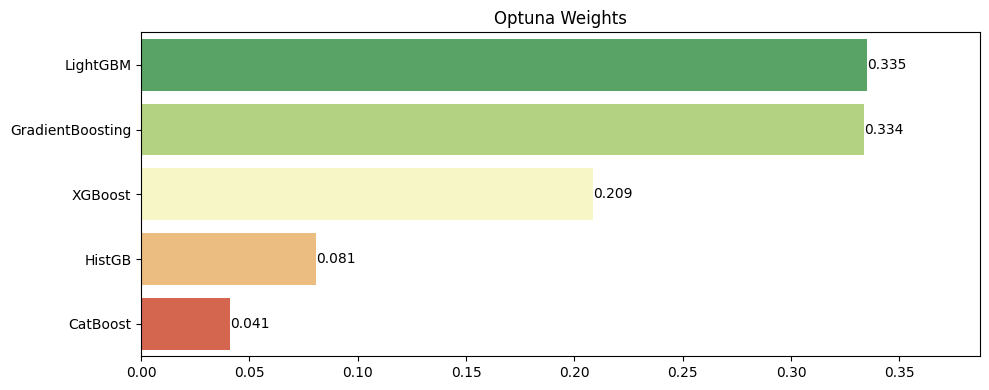

In [23]:
plot_weights('Optuna Weights', best_weights)

To make predictions with this 'model', we can simply use the weights that we found and take the weighted average of the test predictions of each base model.

In [24]:
weighted_test_preds = np.zeros((test.shape[0]))
for model, weight in zip(test_preds.keys(), best_weights):
    weighted_test_preds += test_preds[model] * weight

In [25]:
save_submission(weighted_test_preds, 'weighted-averaging', study.best_value).head()

,id,price
0,188533,17002.016113
1,188534,81096.010986
2,188535,53743.075928
3,188536,25054.089905
4,188537,29610.761597


## Ridge

Instead of tuning ensemble weights, we can use a meta-model that uses the predictions of the base models as features and learns the best way to combine them. The regularized linear model, Ridge, is a popular choice for this purpose. It learns a linear combination of the features and assigns weights to each model that minimizes its error. The L2 regularization term in Ridge penalizes large weights (coefficients), ensuring that no single model dominates the ensemble.

Since we are using predictions as features, it is likely that these features are highly correlated with each other. Ridge tends to be more effective at handling this multicollinearity than the previous method.

Before feeding the predictions to the model, I will create a dataframe out of the prediction and scale the values using `MinMaxScaler`. This gives a small boost to the CV score.

In [26]:
_X = pd.DataFrame(oof_preds)
_X_test = pd.DataFrame(test_preds)

scaler = MinMaxScaler().set_output(transform='pandas')
_X = scaler.fit_transform(_X)
_X_test = scaler.transform(_X_test)

In [27]:
ridge_model = Ridge(
    random_state=CFG.seed,
    alpha=6
)
ridge_trainer = Trainer(ridge_model, CFG, True)
_, ridge_test_preds, scores['Ridge'], ridge_coeffs = ridge_trainer.fit_predict(_X, y, _X_test)

Training Ridge

--- Fold 1 - RMSE: 71770
--- Fold 2 - RMSE: 73149
--- Fold 3 - RMSE: 72607
--- Fold 4 - RMSE: 72026
--- Fold 5 - RMSE: 73342

Overall RMSE: 72581 ± 611


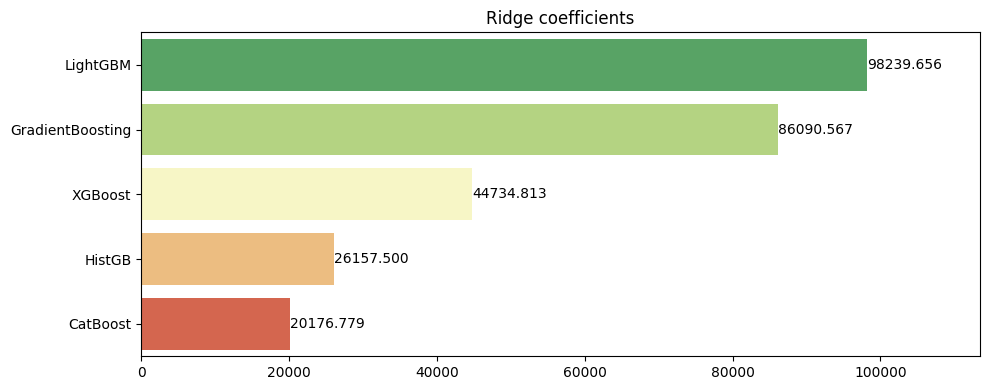

In [28]:
plot_weights('Ridge coefficients', ridge_coeffs)

In [29]:
save_submission(ridge_test_preds, 'ridge', np.mean(scores['Ridge'])).head()

,id,price
0,188533,16556.734375
1,188534,81550.984375
2,188535,53778.671875
3,188536,24844.835938
4,188537,29413.867188


## Lasso

Lasso is another good option when choosing a meta-model for ensembling. Similar to Ridge, Lasso is a regularized linear model. However, unlike Ridge, which includes an L2 regularization term, Lasso has an inbuilt L1 regularization. One interesting property of Lasso is that it can set a models weight to zero, meaning it essentially performs feature selection and discards the least useful features.

In [30]:
lasso_model = Lasso()
lasso_trainer = Trainer(lasso_model, CFG, True)
_, lasso_test_preds, scores['Lasso'], lasso_coeffs = lasso_trainer.fit_predict(_X, y, _X_test)

Training Lasso

--- Fold 1 - RMSE: 71770
--- Fold 2 - RMSE: 73151
--- Fold 3 - RMSE: 72606
--- Fold 4 - RMSE: 72029
--- Fold 5 - RMSE: 73339

Overall RMSE: 72582 ± 610


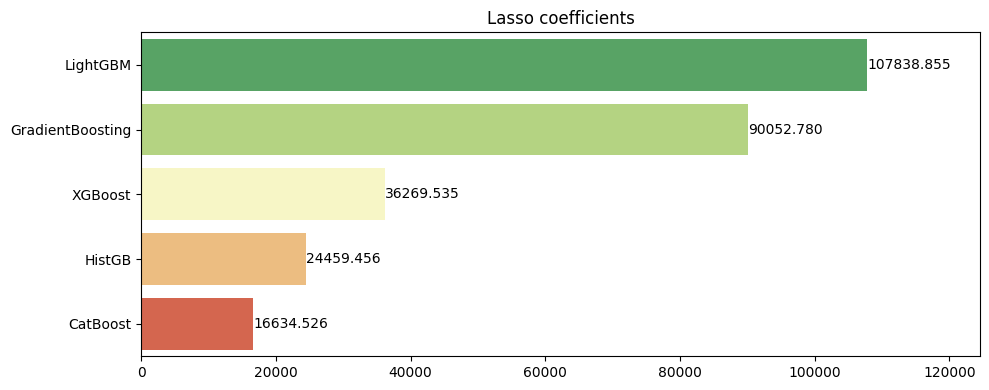

In [31]:
plot_weights('Lasso coefficients', lasso_coeffs)

In [32]:
save_submission(lasso_test_preds, 'lasso', np.mean(scores['Lasso'])).head()

,id,price
0,188533,16550.736328
1,188534,81551.882812
2,188535,53822.171875
3,188536,24791.535156
4,188537,29398.431641


## Hill climbing

In my opinion, hill climbing is an underused ensembling method in competitions. It is a simple, yet effective method to create an ensemble from OOF files. I will use the implementation from a fellow Kaggler. You can learn more about this library [here](https://github.com/Matt-OP/hillclimbers/).

In [33]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [34]:
hc_test_preds, hc_oof_preds = climb_hill(
    train=train, 
    oof_pred_df=pd.DataFrame(oof_preds), 
    test_pred_df=pd.DataFrame(test_preds),
    target=CFG.target,
    objective='minimize', 
    eval_metric=partial(rmse),
    negative_weights=True, 
    precision=0.001, 
    plot_hill=True, 
    plot_hist=False,
    return_oof_preds=True
)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (5 total): 

XGBoost:          72628.19713 (best solo model)
LightGBM:         72647.35699
GradientBoosting: 72660.97930
HistGB:           72689.33956
CatBoost:         72749.33033

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: GradientBoosting | Best weight: 0.411 | Best rmse: 72596.92105
Iteration: 2 | Model added: LightGBM | Best weight: 0.341 | Best rmse: 72578.41626
Iteration: 3 | Model added: CatBoost | Best weight: 0.060 | Best rmse: 72577.72361
Iteration: 4 | Model added: HistGB | Best weight: 0.027 | Best rmse: 72577.64026


In [35]:
hc_score = mean_squared_error(hc_oof_preds, y, squared=False)
scores['Hill Climbing'] = [hc_score] * CFG.n_folds

In [36]:
save_submission(hc_test_preds, 'hill-climbing', hc_score).head()

,id,price
0,188533,16944.951172
1,188534,80988.296875
2,188535,53472.863281
3,188536,25664.400391
4,188537,29486.519531


## Voting

The methods shown previously all use OOF predictions and are generally faster ways to ensemble. Voting, however, re-fits each model that it is given from scratch. The regression version of the voting model averages the predictions from the base models. It can also accept a list of weights and compute the weighted average. It is not very different from the simple averaging model shown earlier.

In [37]:
estimators = [
    ('LightGBM',           LGBMRegressor(**lgbm_params)),
    ('XGBoost',            XGBRegressor(**xgb_params)),
    ('CatBoost',           CatBoostRegressor(**cb_params)),
    ('HistGB',             HistGradientBoostingRegressor(**hgb_params)),
    ('GradientBoosting',   GradientBoostingRegressor(**gb_params))
]

In [38]:
voting_model = VotingRegressor(estimators=estimators)
voting_trainer = Trainer(voting_model, CFG)
_, voting_test_preds, scores['Voting'] = voting_trainer.fit_predict(X, y, X_test)

Training VotingRegressor

--- Fold 1 - RMSE: 71766
--- Fold 2 - RMSE: 73151
--- Fold 3 - RMSE: 72619
--- Fold 4 - RMSE: 72016
--- Fold 5 - RMSE: 73372

Overall RMSE: 72587 ± 622


In [39]:
save_submission(voting_test_preds, 'voting', np.mean(scores['Voting'])).head()

,id,price
0,188533,16876.591797
1,188534,80475.312500
2,188535,52891.406250
3,188536,25169.015625
4,188537,29746.281250


In [40]:
weighted_voting_model = VotingRegressor(estimators=estimators, weights=best_weights)
weighted_voting_trainer = Trainer(weighted_voting_model, CFG)
_, weighted_voting_test_preds, scores['Weighted Voting'] = weighted_voting_trainer.fit_predict(X, y, X_test)

Training VotingRegressor

--- Fold 1 - RMSE: 71766
--- Fold 2 - RMSE: 73144
--- Fold 3 - RMSE: 72605
--- Fold 4 - RMSE: 72014
--- Fold 5 - RMSE: 73336

Overall RMSE: 72576 ± 612


In [41]:
save_submission(weighted_voting_test_preds, 'weighted-voting', np.mean(scores['Weighted Voting'])).head()

,id,price
0,188533,17002.015625
1,188534,81096.015625
2,188535,53743.078125
3,188536,25054.091797
4,188537,29610.759766


## Stacking

Similar to a voting model, a stacking model re-fits a list of models from scratch, and ensembles their predictions. However, unlike voting, it is more complex and uses a meta-model to learn the best combination of the features instead of simply averaging the predictions. Under the hood, it uses `RidgeCV` to ensemble predictions of the base models, however, its meta-model is configurable and can be changed. Here, I will just leave it with the default parameters.

In [42]:
stacking_model = StackingRegressor(estimators=estimators)
stacking_trainer = Trainer(stacking_model, CFG)
_, stacking_test_preds, scores['Stacking'] = stacking_trainer.fit_predict(X, y, X_test)

Training StackingRegressor

--- Fold 1 - RMSE: 71789
--- Fold 2 - RMSE: 73162
--- Fold 3 - RMSE: 72613
--- Fold 4 - RMSE: 72034
--- Fold 5 - RMSE: 73359

Overall RMSE: 72594 ± 612


In [43]:
save_submission(stacking_test_preds, 'stacking', np.mean(scores['Stacking'])).head()

,id,price
0,188533,16513.083984
1,188534,80464.531250
2,188535,53014.531250
3,188536,26012.148438
4,188537,29170.062500


# Results

We can see that all of the ensemble models achieve better scores than the individual models. The difference is not much, but it is enough to give you an edge in the competition. The results also show that some ensembling methods work better than others. There are no general rules for what works best. One has to experiment with different methods and choose an ensembling technique that suits a particular usecase.

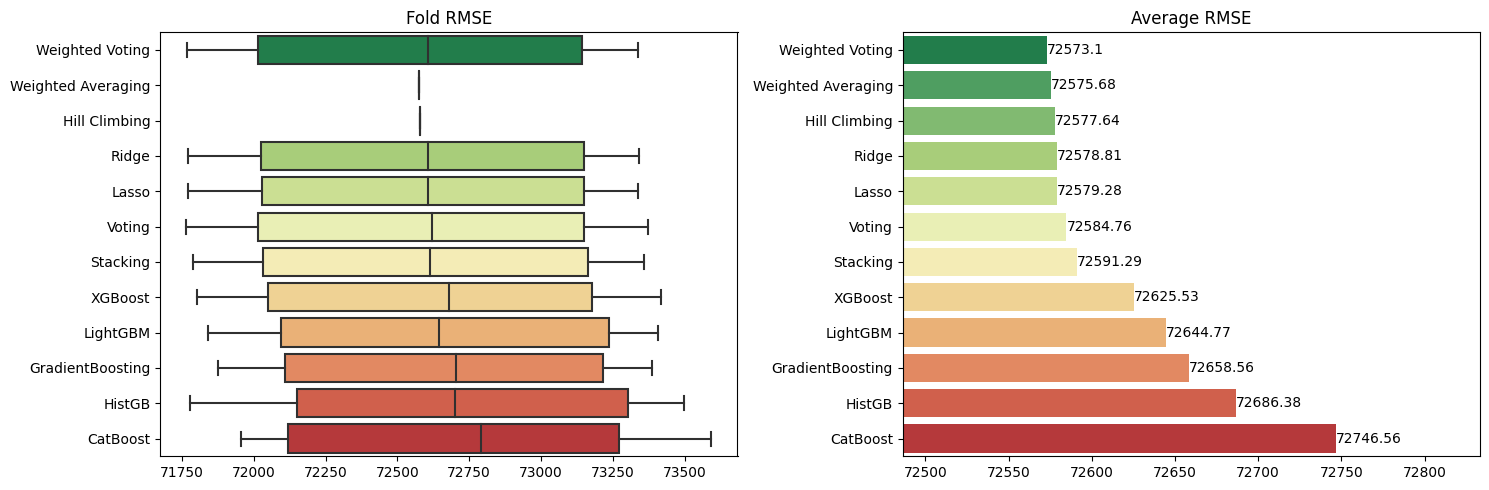

In [44]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette="RdYlGn_r")
axs[0].set_title('Fold RMSE')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title('Average RMSE')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 2), va='center')

plt.tight_layout()
plt.show()

In [45]:
shutil.rmtree('catboost_info')